In [1]:
import torch
import beat_tracking_rnn
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
from constants import *
import datasets
from visualization import *
import preprocessing
import postprocessing
import time
import datetime
from IPython.display import Audio

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
totensor = beat_tracking_rnn.ToTensor(device)

Device: cuda


# Datasets

Take a subset of the GTZAN dataset preprocessed using `preprocess-GTZAN` and split it into a train set and a validation set.

In [2]:
path_n = './data/precomputations/training-01/normal/'
path_s = './data/precomputations/training-01/slow/'
path_f = './data/precomputations/training-01/fast/'

In [3]:
gtzan_n    = datasets.GTZAN(path_n, stretch=None, force_nb_samples=3)
gtzan_s    = datasets.GTZAN(path_s, stretch=4/3,  force_nb_samples=4)
gtzan_f    = datasets.GTZAN(path_f, stretch=2/3,  force_nb_samples=2)
gtzan = gtzan_n + gtzan_s + gtzan_f

ballroom_n    = datasets.BALLROOM(path_n, stretch=None, force_nb_samples=3)
ballroom_s    = datasets.BALLROOM(path_s, stretch=4/3,  force_nb_samples=4)
ballroom_f    = datasets.BALLROOM(path_f, stretch=2/3,  force_nb_samples=2)
ballroom = ballroom_n + ballroom_s + ballroom_f

full_dataset = ballroom + gtzan

In [4]:
N = 50
idxs = np.random.permutation(len(full_dataset))[:N]

In [5]:
dataset = datasets.SubBeatTrackingDataset(full_dataset, idxs)

Precompute the spectrograms

In [6]:
dataset.precompute()

  2.00% | Albums-Chrisanne2-01.003
  4.00% | country.00082.001
  6.00% | blues.00035.002
  8.00% | Albums-Fire-01.002
 10.00% | classical.00085.001
 12.00% | Media-104012.000
 14.00% | disco.00046.000
 16.00% | Media-104103.001
 18.00% | Media-105408.002
 20.00% | rock.00017.001
 22.00% | classical.00023.000
 24.00% | metal.00055.003
 26.00% | Albums-Latin_Jam2-02.000
 28.00% | jazz.00034.000
 30.00% | hiphop.00029.000
 32.00% | classical.00020.001
 34.00% | disco.00004.000
 36.00% | metal.00018.003
 38.00% | country.00023.001
 40.00% | pop.00019.003
 42.00% | jazz.00002.002
 44.00% | reggae.00020.001
 46.00% | rock.00084.002
 48.00% | Media-106118.002
 50.00% | Albums-Ballroom_Classics4-09.003
 52.00% | Media-103911.000
 54.00% | Media-103905.000
 56.00% | Albums-Cafe_Paradiso-03.001
 58.00% | Media-104305.000
 60.00% | Albums-Macumba-16.001
 62.00% | disco.00075.000
 64.00% | classical.00080.001
 66.00% | Media-103704.001
 68.00% | Media-105905.002
 70.00% | hiphop.00054.001
 72.00% 

Visualize an example.

In [9]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')
spec, onsets, isbeat = dataset[i]
beats = dataset.get_beats(i)

46/50


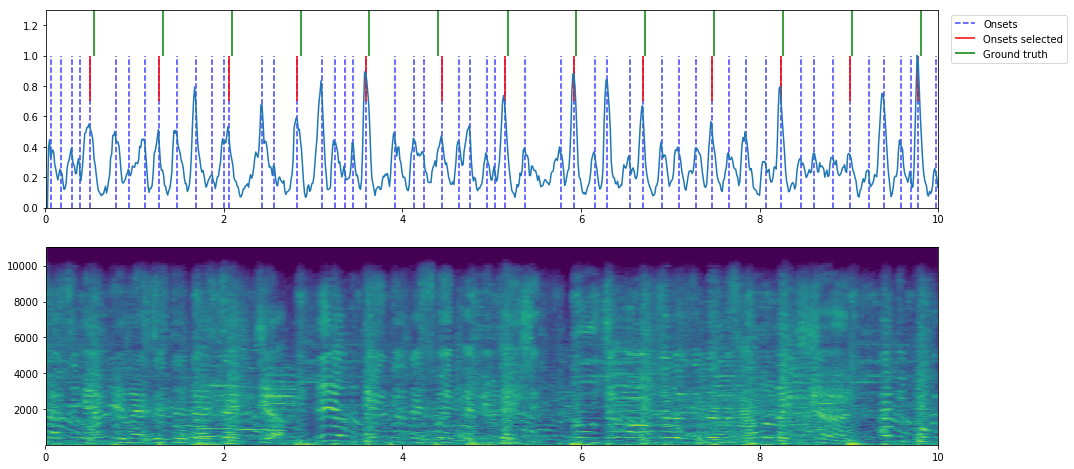

In [10]:
showdata(spec, onsets, isbeat, beats)

In [ ]:
wav = dataset.get_wav(i)
clicks = librosa.clicks(beats, sr=sr, length=len(wav))
Audio(wav + clicks / 2, rate=sr)

In [ ]:
corrected_beats = postprocessing.correct_beats(onsets, beats)
corrected_isbeat = preprocessing.correct_isbeat(onsets, corrected_beats)
showdata(spec, onsets, corrected_isbeat, corrected_beats)

In [ ]:
wav = dataset.get_wav(i)
clicks = librosa.clicks(corrected_beats, sr=sr, length=len(wav))
Audio(wav + clicks / 2, rate=sr)

# Make training and validation sets

In [11]:
totensor = beat_tracking_rnn.ToTensor(device)
dataset.set_transform(totensor)

In [12]:
p = 0.8
train_size = int(p * len(dataset))
indices = list(np.random.permutation(len(dataset)))
trainset = Subset(dataset, indices[:train_size])
validset = Subset(dataset, indices[train_size:])

print(f'Full set size: {len(dataset)}')
print(f'   Train size: {len(trainset)}')
print(f'   Valid size: {len(validset)}')

Full set size: 50
   Train size: 40
   Valid size: 10


# Find learning rate

In [13]:
model = beat_tracking_rnn.BeatTracker()
model.to(device)

BeatTracker(
  (lstm): LSTM(256, 256, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (hid_to_beat): Linear(in_features=512, out_features=2, bias=True)
  (loss_function): NLLLoss()
)

Make an array of learning rates.

In [14]:
dataloader = DataLoader(trainset, batch_size=4, shuffle=True)
n_mb = len(dataloader) # number of mini batches
print(f'{n_mb} mini batches')
lr = (10. ** -np.arange(0, 5, 5 / n_mb))[::-1]

10 mini batches


Then find lr

In [15]:
losses = np.zeros(n_mb)
for i, (specs, onsets, isbeat) in enumerate(dataloader):
    model.set_lr(lr[i])
    tn, fp, fn, tp, loss = model.learn(specs, onsets, isbeat)
    losses[i] = loss
    print(f'{i + 1}/{n_mb}')

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


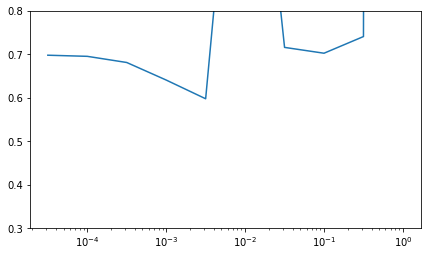

In [16]:
plt.figure(figsize=(7, 4))
plt.ylim(0.3, 0.8)
plt.semilogx(lr, losses);

Something like `lr=0.0005` seems like a good fit.

# Training of the model

In [24]:
model = beat_tracking_rnn.BeatTracker()
model.to(device)
model.set_lr(0.0005)
print_params(model)
model.eval()
model.freeze()

 ----------------------------------------------------------
| lstm.weight_ih_l0            | [1024, 256]  |    262,144 |
| lstm.weight_hh_l0            | [1024, 256]  |    262,144 |
| lstm.bias_ih_l0              | [1024]       |      1,024 |
| lstm.bias_hh_l0              | [1024]       |      1,024 |
| lstm.weight_ih_l0_reverse    | [1024, 256]  |    262,144 |
| lstm.weight_hh_l0_reverse    | [1024, 256]  |    262,144 |
| lstm.bias_ih_l0_reverse      | [1024]       |      1,024 |
| lstm.bias_hh_l0_reverse      | [1024]       |      1,024 |
| lstm.weight_ih_l1            | [1024, 512]  |    524,288 |
| lstm.weight_hh_l1            | [1024, 256]  |    262,144 |
| lstm.bias_ih_l1              | [1024]       |      1,024 |
| lstm.bias_hh_l1              | [1024]       |      1,024 |
| lstm.weight_ih_l1_reverse    | [1024, 512]  |    524,288 |
| lstm.weight_hh_l1_reverse    | [1024, 256]  |    262,144 |
| lstm.bias_ih_l1_reverse      | [1024]       |      1,024 |
| lstm.bias_hh_l1_reverse

Evaluate

In [25]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -------------------
| tp:   0 | fp:   5 |
| fn: 185 | tn: 353 |
 -------------------


ZeroDivisionError: float division by zero

In [21]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(trainset)
confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -------------------
| tp:   0 | fp:   0 |
| fn: 144 | tn: 362 |
 -------------------
 Accuracy: 0.7154
Precision: 0.0000
   Recall: 0.0000
F-measure: 0.0000
     Loss: 0.6860


Train

In [22]:
model.unfreeze()
model.train();

In [23]:
train_hist, valid_hist = model.fit(trainset, validset, batch_size=2, epochs=10)

| Epoch  1 | TL:  0.6305 | VL:  0.6160 | TF: 0.3488 | VF: 0.0000 | 6.19 s/b | 0:00:24 | ETA: 0:03:42 |
| Epoch  2 | TL:  0.5560 | VL:  0.6336 | TF: 0.5075 | VF: 0.3704 | 5.94 s/b | 0:00:23 | ETA: 0:03:10 |
| Epoch  3 | TL:  0.5036 | VL:  0.6691 | TF: 0.5481 | VF: 0.3793 | 6.07 s/b | 0:00:24 | ETA: 0:02:50 |
| Epoch  4 | TL:  0.5101 | VL:  0.7797 | TF: 0.4710 | VF: 0.4255 | 5.92 s/b | 0:00:23 | ETA: 0:02:22 |
| Epoch  5 | TL:  0.4314 | VL:  0.7449 | TF: 0.4028 | VF: 0.4068 | 5.84 s/b | 0:00:23 | ETA: 0:01:56 |
| Epoch  6 | TL:  0.4044 | VL:  0.5580 | TF: 0.5101 | VF: 0.6126 | 5.74 s/b | 0:00:22 | ETA: 0:01:31 |
| Epoch  7 | TL:  0.3648 | VL:  0.6205 | TF: 0.3519 | VF: 0.4375 | 5.73 s/b | 0:00:22 | ETA: 0:01:08 |
| Epoch  8 | TL:  0.3166 | VL:  0.6582 | TF: 0.5132 | VF: 0.5942 | 5.70 s/b | 0:00:22 | ETA: 0:00:45 |
| Epoch  9 | TL:  0.3062 | VL:  0.5152 | TF: 0.3899 | VF: 0.6306 | 5.77 s/b | 0:00:23 | ETA: 0:00:23 |
| Epoch 10 | TL:  0.3055 | VL:  0.4494 | TF: 0.5238 | VF: 0.6796 | 5.92 s

In [ ]:
# torch.save(model.state_dict(), './data/model_08.pt')

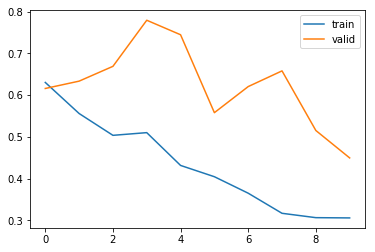

In [24]:
plt.plot(np.mean(train_hist[:, :, 4], axis=1), label='train')
plt.plot(valid_hist[:, 4], label='valid')
plt.legend();

Reevaluate

In [25]:
model.eval()
model.freeze()

In [26]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(validset)
confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -----------------
| tp: 35 | fp: 28 |
| fn:  7 | tn: 75 |
 -----------------
 Accuracy: 0.7586
Precision: 0.5556
   Recall: 0.8333
F-measure: 0.6667
     Loss: 0.4525


In [27]:
tn, fp, fn, tp, loss = model.evaluate_from_dataset(trainset)
confusion(tn, fp, fn, tp)
print(f'     Loss: {loss:.4f}')

 -------------------
| tp: 116 | fp:  12 |
| fn:  28 | tn: 350 |
 -------------------
 Accuracy: 0.9209
Precision: 0.9062
   Recall: 0.8056
F-measure: 0.8529
     Loss: 0.2170


# Test

In [28]:
from IPython.display import Audio
import librosa.display

def unibatch(spec_np, onsets_np, isbeat_np):
    """ Get a minibatch of one sample from the original numpy data."""
    spec, onsets, isbeat = totensor((spec_np, onsets_np, isbeat_np))
    spec = spec.unsqueeze(0)
    onsets = onsets.unsqueeze(0)
    isbeat = isbeat.unsqueeze(0)
    return spec, onsets, isbeat

Load the pretrained model and freeze its parameters.

In [ ]:
model = beat_tracking_rnn.BeatTracker()
model.load_state_dict(torch.load('./data/model_07.pt', map_location=device))
model.eval()
model.freeze()

Take a dataset

In [29]:
dataset.set_transform(None)

Take a random sample

In [30]:
i = np.random.randint(len(dataset))
print(f'{i}/{len(dataset)}')

3/10


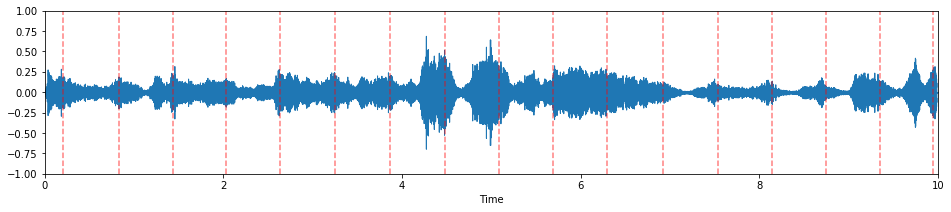

In [31]:
wav = dataset.get_wav(i)
beats = dataset.get_beats(i)
plt.figure(figsize=(16, 3))
librosa.display.waveplot(wav, sr)
plt.vlines(beats, -1, 1, color='r', alpha=0.5, linestyles='--')
plt.ylim(-1, 1);
clicks = librosa.clicks(times=beats, sr=sr, length=len(wav))
Audio(wav + clicks, rate=sr)

In [32]:
spec_np, onsets_np, isbeat_np = dataset[i]
beats_np = dataset.get_beats(i)

Compute the beat track from the RNN algorithm and compare with librosa and ground truth.

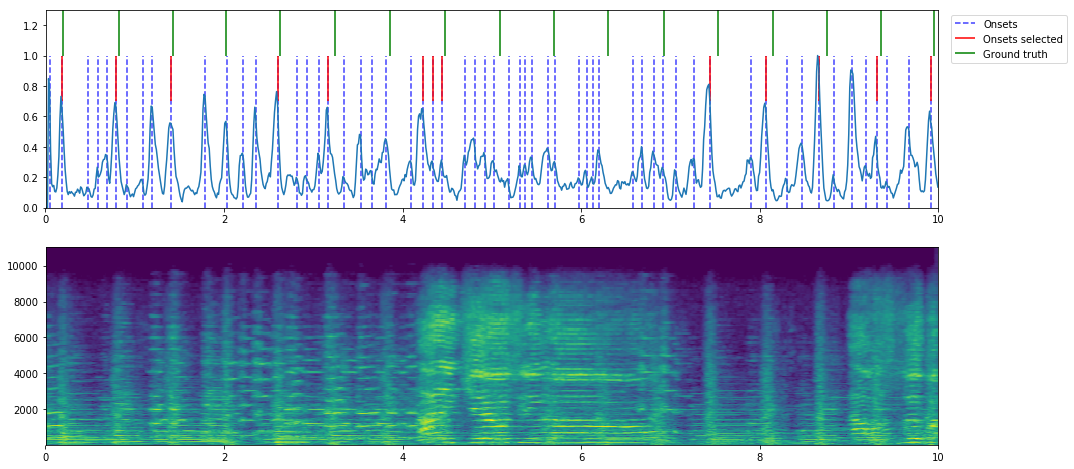

In [33]:
# RNN
spec, onsets, isbeat = unibatch(spec_np, onsets_np, isbeat_np)
pred = model.predict(spec, onsets)
pred_onset_envelope = pred.squeeze(0).numpy()
pred_isbeat_np = pred_onset_envelope[onsets_np]
onsets_selected_times = librosa.frames_to_time(onsets_np[pred_isbeat_np == 1], sr, hl)
showdata(spec_np, onsets_np, pred_isbeat_np, beats_np)

In [35]:
postprocessing.ground_truth_bpm(beats_np)

98.43744232181115

98.57161103542232


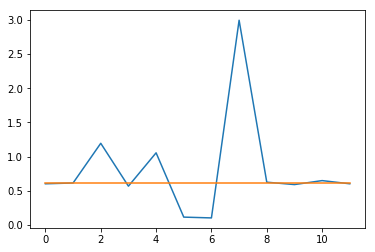

In [36]:
bpm = postprocessing.bpm_estimation(pred_onset_envelope)

In [37]:
# Dynamic programming
beats_frames = np.argwhere(pred.squeeze(0).numpy() == 1).flatten()
max_frame = pred.shape[1]
sbt = librosa.frames_to_time(postprocessing.beat_tracker(beats_frames, max_frame, bpm, 500), sr, hl)

In [38]:
# Librosa
onset_envelope = librosa.onset.onset_strength(wav, sr, hop_length=hl)
tempo, bt_lib  = librosa.beat.beat_track(onset_envelope=onset_envelope, sr=sr, hop_length=hl)
bt_lib_times   = librosa.frames_to_time(bt_lib, sr, hl)

/anaconda3/envs/audio/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


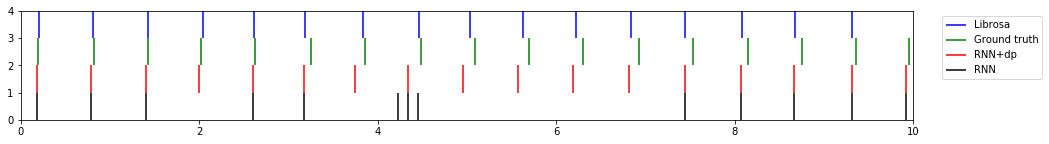

In [39]:
plt.figure(figsize=(16, 2))
plt.vlines(bt_lib_times, 3, 4, color='b', label='Librosa')
plt.vlines(beats_np, 2, 3, color='g', label='Ground truth')
plt.vlines(sbt, 1, 2, color='r', label="RNN+dp")
plt.vlines(onsets_selected_times, 0, 1, color='k', label='RNN')
plt.xlim(0, 10)
plt.ylim(0, 4)
plt.legend(frameon=True, framealpha=0.75, bbox_to_anchor=(1.15, 1));

Listen to the three different beat tracks.

In [40]:
# No click
wav = dataset.get_wav(i)
Audio(wav, rate=sr)

In [41]:
# RNN + dynamical programming
click = librosa.clicks(sbt, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [ ]:
# Librosa
click = librosa.clicks(bt_lib_times, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

In [ ]:
# Ground truth
click = librosa.clicks(beats_np, length=len(wav), sr=sr)
Audio(wav + click, rate=sr)

# Evalutation

In [ ]:
from IPython.display import Audio
import postprocessing
import preprocessing

In [ ]:
ballroom = datasets.BALLROOM('./data/BALLROOM', force_nb_samples=3)
gtzan = datasets.GTZAN('./data/GTZAN/', force_nb_samples=3)
dataset = gtzan

In [ ]:
idxs = list(np.random.permutation(len(dataset))[:100])
for i in idxs: print(f'{i}  ', end='')

In [ ]:
subdataset = datasets.SubBeatTrackingDataset(dataset, idxs)

In [ ]:
subdataset.set_transform(None)

In [ ]:
subdataset.precompute()

In [ ]:
i = np.random.randint(len(subdataset))
print(i)
beats = subdataset.get_beats(i)
spec, onsets, isbeat = subdataset[i]
showdata(spec, onsets, isbeat, beats)

In [ ]:
wav = subdataset.get_wav(i)
clicks = librosa.clicks(beats, sr=sr, length=len(wav))
Audio(wav + clicks, rate=sr)

In [ ]:
corrected_beats = postprocessing.correct_beats(onsets, beats)
corrected_isbeat = preprocessing.correct_isbeat(onsets, corrected_beats)

In [ ]:
showdata(spec, onsets, corrected_isbeat, corrected_beats)

In [ ]:
model = beat_tracking_rnn.BeatTracker()
model.load_state_dict(torch.load('./data/pretrained-models/model_07.pt', map_location=device))
model.eval()
model.freeze()

In [ ]:
totensor = beat_tracking_rnn.ToTensor(device)
subdataset.set_transform(totensor)

In [ ]:
tn, fp, fn, tp = model.evaluate_from_dataset(subdataset)

In [ ]:
confusion(tn, fp, fn, tp)